# An introduction of RDKit utilities
RDKit is an open-source cheminformatics software that allows users to manipulate and analyze chemical structures, molecules, and molecualr data. It is widely used in drug discovery and materials science for tasks such as molecular modeling, property prediction, and virtual screening. Adapted from a part of [demonstration](https://www.rdkit.org/docs/GettingStartedInPython.html#) in the RDKit documentation, this notebooks demonstrates some common utilities of RDKit, with additional explanations and examples. The very detailed documentation can be found at https://www.rdkit.org/docs/index.html, and the project is hosted on GitHub at https://github.com/rdkit/rdkit. Note that in addition to some less relevant examples, the following sections in the documentation are not covered in this notebook:
- Chemical reactions
- R-group decomposition
- Non-chemical functionality
- Miscellaneous Tips and Hints
- List of available descriptors
- List of available 3D descriptors
- List of available fingerprints
- Feature definitions used in the Morgan fingerprints

Here is a table of content of this notebook:
- [1. Reading, drawing, and writing molecules](#1.-Reading,-drawing,-and-writing-molecules)
- [2. Working with molecules](#2.-Working-with-molecules)
- [3. Substructure searching](#3.-Substructure-searching)
- [4. Chemical transformations](#4.-Chemical-transformations)
- [5. Maximum Common Substructure](#5.-Maximum-Common-Substructure)
- [6. Fingerprinting and molecular similarity](#6.-Fingerprinting-and-molecular-similarity)
- [7. Descriptor calculation](#7.-Descriptor-calculation)
- [8. Chemical features and pharmacophores](#8.-Chemical-features-and-pharmacophores)
- [9. Molecular fragments](#9.-Molecular-fragments)
- [10. Getting help](#12.-Getting-help)
- [11. Advanced topics/warnings](#13.-Advanced-topics/warnings)
- [12. Filtering molecular datasets](#14.-Filtering-molecular-datasets)

## 1. Reading, drawing, and writing molecules
### 1.1. Some terminologies
- **SMILES**: Simplified Molecular Input Line Entry System is a line notation for describing the structure of chemical species using short ASCII strings. It is a popular way to represent chemical structures in a human-readable format. For more information, please see https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system
- **SMARTS**: SMILES arbitrary target specification (SMARTS) is a language for specifying substructural patterns in molecules. The SMARTS line notation is expressive and allows extremely precise and transparent substructural specification and atom typing. For information, see https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
- **InChI**: The International Chemical Identifier (InChI) is a textual identifier for chemical substances, designed to provide a standard way to encode molecular information and to facilitate the search for such information in databases and on the web. For more information, see https://en.wikipedia.org/wiki/International_Chemical_Identifier

### 1.2. Reading single molecules

Individual molecules can be constructed using a variety of approaches. Note that when construing a molecule from a file, hydrogen atoms are all removed by default. This can be changed by setting the `removeHs` parameter to `False`.

In [1]:
from rdkit import Chem

# 1. Create a molecule from a SMILES string
mol_1 = Chem.MolFromSmiles('CCO')

# 2. Create a molecule from a MOL file
mol_2 = Chem.MolFromMolFile('../data/alanine.mol')

# 3. Create a molecule from a SDF file
mol_3 = Chem.SDMolSupplier('../data/alanine.sdf')[0]  # there is only one molecule in the file

# 4. Create a molecule from a PDB file
mol_4 = Chem.MolFromPDBFile('../data/analnine_dipeptide.pdb')

# 5. Create a molecule from an InChI string
mol_5 = Chem.MolFromInchi('InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H')

Alternatively, a mol file can also be read using the `Chem.MolFromMolBlock` function.

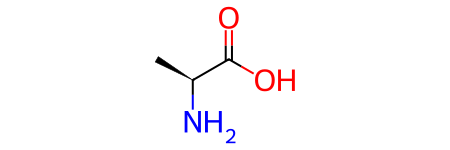

In [2]:
stringWithMolData=open('../data/alanine.mol','r').read()  # This also works for SDF files
Chem.MolFromMolBlock(stringWithMolData)

A full list of `MolFrom*` functions for constructing a molecule using RDKit is as follows. More information can be found in the [documentation](https://www.rdkit.org/docs/source/rdkit.Chem.html).
- `MolFromFASTA()`
- `MolFromHELM()`
- `MolFromMol2Block()`
- `MolFromMol2File()`
- `MolFromMolBlock()`
- `MolFromMolFile()`
- `MolFromMrvBlock()`
- `MolFromMrvFile()`
- `MolFromPDBBlock()`
- `MolFromPDBFile()`
- `MolFromPNGFile()`
- `MolFromPNGString()`
- `MolFromRDKitSVG()`
- `MolFromSequence()`
- `MolFromSmarts()`
- `MolFromSmiles()`
- `MolFromTPLBlock()`
- `MolFromTPLFile()`
- `MolFromXYZBlock()`
- `MolFromXYZFile()`

All of these functions return a `rdkit.Chem.rd.chem.Mol` object on success, or `None` on failure. RDKit will attempt to provide a useful error message if the input is invalid. See the example below:


In [3]:
m = Chem.MolFromSmiles('CO(C)C')

[02:23:17] Explicit valence for atom # 1 O, 3, is greater than permitted


In [4]:
m is None

True

Notably, an `rdkit.Chem.rdchem.Mol` object can be displayed graphically using `rdkit.Chem.Draw.MolToImage()`:

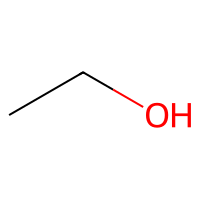

In [5]:
from rdkit.Chem import Draw
Draw.MolToImage(mol_1, size=(200, 200))

To display multiple images, one can use `rdkit.Chem.Draw.MolsToGridImage()`:

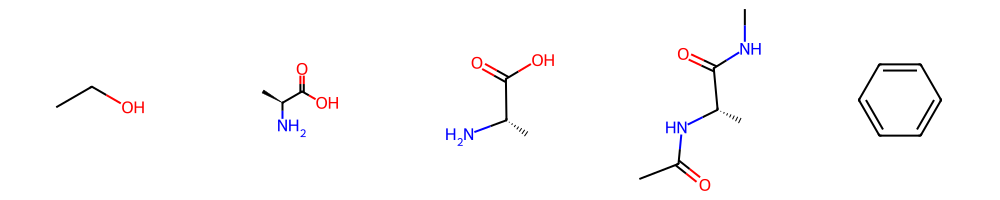

In [6]:
Draw.MolsToGridImage([mol_1, mol_2, mol_3, mol_4, mol_5], molsPerRow=5, subImgSize=(200, 200))

### 1.2. Reading sets of molecules
Groups of molecules are read using a Supplier (for example, an `rdkit.Chem.rdmolfiles.SDMolSupplier` or a `rdkit.Chem.rdmolfiles.SmilesMolSupplier`):

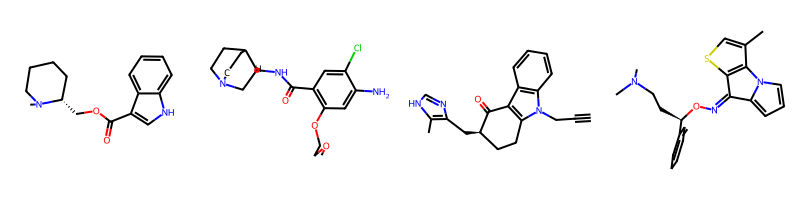

In [7]:
suppl = Chem.SDMolSupplier('../data/5ht3ligs.sdf')
Draw.MolsToGridImage([x for x in suppl if x is not None], molsPerRow=len(suppl), subImgSize=(200, 200))

Two good practices when working with Suppliers are to use a context manager and to test each molecule to see if it was correctly read before working with it:

In [8]:
with Chem.SDMolSupplier('../data/5ht3ligs.sdf') as suppl:
  for mol in suppl:
    if mol is None: 
        continue
    print(mol.GetNumAtoms())  # Print the number of atoms in each molecule. We'll explore more methods later.

20
24
24
26


An alternate type of Supplier, the `rdkit.Chem.rdmolfiles.ForwardSDMolSupplier` can be used to read from file-like objects. Note, however, that `ForwardSDMolSupplier` does not support indexing.

In [9]:
inf = open('../data/5ht3ligs.sdf','rb')
with Chem.ForwardSDMolSupplier(inf) as fsuppl:
  for mol in fsuppl:
    if mol is None: 
        continue
    print(mol.GetNumAtoms())

20
24
24
26


This means that they can be used to read from compressed files:

In [10]:
import gzip
inf = gzip.open('../data/actives_5ht3.sdf.gz')
with Chem.ForwardSDMolSupplier(inf) as gzsuppl:
   ms = [x for x in gzsuppl if x is not None]
len(ms)

180

For reading Smiles or SDF files with large number of records concurrently, `MultithreadedMolSuppliers` can be used like this:

In [11]:
i = 0
with Chem.MultithreadedSDMolSupplier('../data/5ht3ligs.sdf') as sdSupl:
  for mol in sdSupl:
    if mol is not None:
      i += 1

print(i)

4


By default a single reader thread is used to extract records from the file and a single writer thread is used to process them. Note that due to multithreading the output may not be in the expected order. Furthermore, the `MultithreadedSmilesMolSupplier` and the `MultithreadedSDMolSupplier` do not support indexing.

### 1.3. Writing molecules
Single molecules can be converted to text using several functions present in the `rdkit.Chem module`. For example, for a SMILES string:

In [12]:
m = Chem.MolFromMolFile('../data/chiral.mol')
Chem.MolToSmiles(m)

'C[C@H](O)c1ccccc1'

Notably, in `'C[C@H](O)c1ccccc1'`, `[C@H]` represents a chiral center, where `@` indicates the specific stereochemistry (chirality) of the atom. Using `Chem.MolToSmiles`, we can choose to include or exclude stereochemistry information by setting the `isomericSmiles` parameter to `True` or `False`, respectively.

In [13]:
print(Chem.MolToSmiles(m, isomericSmiles=True))
print(Chem.MolToSmiles(m, isomericSmiles=False))

C[C@H](O)c1ccccc1
CC(O)c1ccccc1


Note that the SMILES provided is canonical, so the output should be the same no matter how a particular molecule is input:

In [14]:
print(Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('c1cccnc1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('n1ccccc1')))

c1ccncc1
c1ccncc1
c1ccncc1


MDL Mol blocks are also available:

In [15]:
m2 = Chem.MolFromSmiles('C1CCC1')
print(Chem.MolToMolBlock(m2))    


     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



To include names in the mol blocks, set the molecule’s “_Name” property:

In [16]:
m2.SetProp("_Name","cyclobutane")
print(Chem.MolToMolBlock(m2))    

cyclobutane
     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



In order for atom or bond stereochemistry to be recognised correctly by most software, it’s essential that the mol block have atomic coordinates. It’s also convenient for many reasons, such as drawing the molecules. Generating a mol block for a molecule that does not have coordinates will, by default, automatically cause coordinates to be generated. These are not, however, stored with the molecule. Coordinates can be generated and stored with the molecule using functionality in the `rdkit.Chem.AllChem` module.

**Supplementary note**: Chem vs AllChem

The majority of “basic” chemical functionality (e.g. reading/writing molecules, substructure searching, molecular cleanup, etc.) is in the `rdkit.Chem` module. More advanced, or less frequently used, functionality is in `rdkit.Chem.AllChem`. The distinction has been made to speed startup and lower import times; there’s no sense in loading the 2D->3D library and force field implementation if one is only interested in reading and writing a couple of molecules. 

In [17]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(m2)
print(Chem.MolToMolBlock(m2))     

cyclobutane
     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



Or you can add 3D coordinates by embedding the molecule (this uses the ETKDG method, which is described in more detail below). Note that we add Hs to the molecule before generating the conformer. This is essential to get good structures:

In [18]:
m3 = Chem.AddHs(m2)
params = AllChem.ETKDGv3()
params.randomSeed = 0xf00d # optional random seed for reproducibility
AllChem.EmbedMolecule(m3, params)
print(Chem.MolToMolBlock(m3))    

cyclobutane
     RDKit          3D

 12 12  0  0  0  0  0  0  0  0999 V2000
    1.0256    0.2491   -0.0964 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2041    0.9236    0.4320 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0435   -0.2466   -0.0266 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2104   -0.9922   -0.3417 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4182    0.7667   -0.9782 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.8181    0.1486    0.6820 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1697    1.0826    1.5236 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5336    1.8391   -0.1051 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6809   -0.0600   -0.8987 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6501   -0.6194    0.8220 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.4659   -1.7768    0.3858 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.3439   -1.3147   -1.3988 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
  1  5  1  0
  1  6  1  0
  2  7

If we don’t want the Hs in our later analysis, they are easy to remove:

In [19]:
m3 = Chem.RemoveHs(m3)
print(Chem.MolToMolBlock(m3))    

cyclobutane
     RDKit          3D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0256    0.2491   -0.0964 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2041    0.9236    0.4320 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0435   -0.2466   -0.0266 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2104   -0.9922   -0.3417 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



If you’d like to write the molecule to a file, simply use Python file objects:

In [20]:
print(Chem.MolToMolBlock(m2),file=open('../data/foo.mol','w+'))

# Here we remove the file just to not leave it around
import os
os.remove('../data/foo.mol')

### 1.4. Writing sets of molecules
Multiple molecules can be written to a file using an `rdkit.Chem.rdmolfiles.SDWriter` object. Note that an SDWriter can also be initialized using a file-like object (see the documentation for more information). Other available Writers include the `rdkit.Chem.rdmolfiles.SmilesWriter` and the `rdkit.Chem.rdmolfiles.TDTWriter`.

In [21]:
mols = [Chem.MolFromSmiles('C[C@H](O)c1ccccc1'), Chem.MolFromSmiles('C[C@@H](O)c1ccccc1')]
with Chem.SDWriter('../data/foo.sdf') as w:
  for m in mols:
    w.write(m)

os.remove('../data/foo.sdf')

## 2. Working with molecules

### 2.1. Looping over atoms and bonds
Once you have a molecule, it’s easy to loop over its atoms and bonds:

In [27]:
m = Chem.MolFromSmiles('C1OC1')
for atom in m.GetAtoms():
  print(atom.GetAtomicNum())
print(m.GetBonds()[0].GetBondType())

6
8
6
SINGLE


You can also request individual bonds or atoms:

In [28]:
print(m.GetAtomWithIdx(0).GetSymbol())
print(m.GetAtomWithIdx(0).GetExplicitValence())
print(m.GetBondWithIdx(0).GetBeginAtomIdx())
print(m.GetBondWithIdx(0).GetEndAtomIdx())
print(m.GetBondBetweenAtoms(0,1).GetBondType())

C
2
0
1
SINGLE


Atoms keep track of their neighbors:

In [29]:
atom = m.GetAtomWithIdx(0)
print([x.GetAtomicNum() for x in atom.GetNeighbors()])
print(len(atom.GetNeighbors()[-1].GetBonds()))

[8, 6]
2


### 2.2. Ring information
Atoms and bonds both carry information about the molecule’s rings:

In [31]:
m = Chem.MolFromSmiles('OC1C2C1CC2')
print(m.GetAtomWithIdx(0).IsInRing())
print(m.GetAtomWithIdx(2).IsInRingSize(3))
print(m.GetBondWithIdx(1).IsInRing())
print(m.GetBondWithIdx(1).IsInRingSize(3))

False
True
True
True


But note that the information is only about the smallest rings:

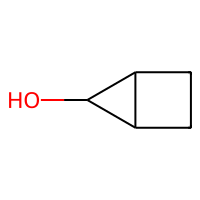

In [34]:
Draw.MolsToImage([m])

In [35]:
print(m.GetAtomWithIdx(1).IsInRingSize(5))

False


More detail about the smallest set of smallest rings (SSSR) is available:

In [40]:
ssr = Chem.GetSymmSSSR(m)
print(ssr)
print(len(ssr))
print(list(ssr[0]))
print(list(ssr[1]))

2
[1, 2, 3]
[4, 5, 2, 3]


2
[1, 2, 3]
[4, 5, 2, 3]


As the name indicates, this is a symmetrized SSSR; if you are interested in the number of “true” SSSR, use the GetSSSR function (note that in this case there’s no difference).

In [41]:
len(Chem.GetSSSR(m))

2

For more efficient queries about a molecule’s ring systems (avoiding repeated calls to `Mol.GetAtomWithIdx`), use the `rdkit.Chem.rdchem.RingInfo` class:

In [45]:
ri = m.GetRingInfo()
print(ri.NumAtomRings(0))  # number of rings that atom 0 is in
print(ri.IsAtomInRingOfSize(1,3))  # is atom 1 in a 3-membered ring?
print(ri.IsBondInRingOfSize(1,3))  # is bond 1 in a 3-membered ring?


0
True
True


### 2.3. Modifying molecules
Normally molecules are stored in the RDKit with the hydrogen atoms implicit (e.g. not explicitly present in the molecular graph. When it is useful to have the hydrogens explicitly present, for example when generating or optimizing the 3D geometry, the `rdkit.Chem.rdmolops.AddHs` function can be used:

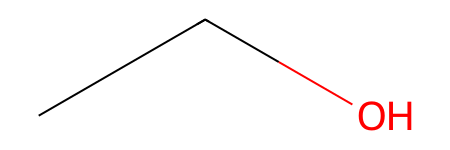

In [46]:
m=Chem.MolFromSmiles('CCO')
m.GetNumAtoms()
m

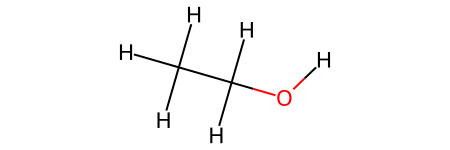

In [47]:
m2 = Chem.AddHs(m)
m2.GetNumAtoms()
m2 

The Hs can be removed again using the `rdkit.Chem.rdmolops.RemoveHs()` function:

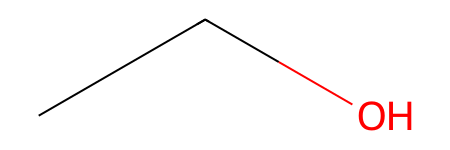

In [48]:
m3 = Chem.RemoveHs(m2)
m3.GetNumAtoms()
m3 

### 2.4. Working with 2D molecules: Generating depictions


### 2.5. Working with 3D molecules

### 2.6. Preserving molecules

### 2.7. Drawing molecules

### 2.8. Metadata in molecule images

## 3. Substructure searching

### 3.1. Stereochemistry in substructure matches

### 3.2. Atom map indices in SMARTS

### 3.3. Advanced substructure matching

### 3.4. Advanced substructure matching

## 4. Chemical transformations

### 4.1. Substructure-based transformations

### 4.2. Murcko decomposition

## 5. Maximum common substructure

### 5.1. FindMCS

### 5.2. RascalMCES

### 5.3. Clustering with Rascal

## 6. Fingerprinting and molecular similarity

### 6.1. RDKit (topological) fingerprints

### 6.2. Atom pairs and topological torsions

### 6.3. Morgan fingerprints (circular fingerprints)

### 6.4. MACCS keys

### 6.5. Explaining bits from fingerprints

#### 6.5.1. Morgan fingerprints

#### 6.5.2. RDKit fingerprints

### 6.6. Generating images of fingerprint bits

### 6.7. Picking diverse molecules using fingerprints

### 6.8. Generating similarity maps using fingerprints

## 7. Descriptor calculation

### 7.1. Calculating all descriptors

### 7.2. calculating partial charges

### 7.3. Visualization of descriptors

## 8. Chemical features and pharmacophores

### 8.1. Chemical features

### 8.2. 2D pharmacophore fingerprints

## 9. Molecular fragments

## 10. Getting help

## 11. Advanced topics/warnings

## 12. Filtering molecular datasets

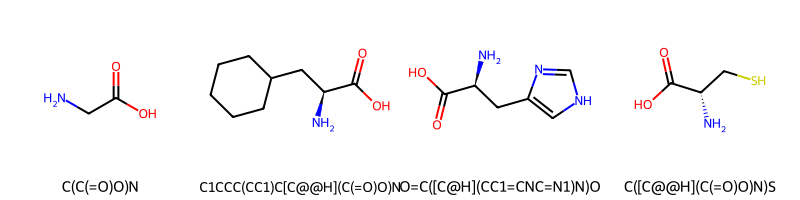

In [23]:
# smiles strings of glycine, phenylalanine, histidine, and cysteine
smiles_list = [
    'C(C(=O)O)N', 
    'C1CCC(CC1)C[C@@H](C(=O)O)N',
    'O=C([C@H](CC1=CNC=N1)N)O',
    'C([C@@H](C(=O)O)N)S'
]

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, legends=smiles_list)
img

In [24]:
pattern_1 = Chem.MolFromSmiles('C(=O)O')  # carboxyl group
pattern_2 = Chem.MolFromSmiles('S')
pattern_3 = Chem.MolFromSmarts('[r5]')  # SMARTS string for a five-membered ring

import prettytable as pt
table = pt.PrettyTable()
table.field_names = ['Pattern', 'Glycine', 'Phenylalanine', 'Histidine', 'Cysteine']
table.add_row(['Carboxyl group'] + [mol.HasSubstructMatch(pattern_1) for mol in mol_list])
table.add_row(['Sulfur'] + [mol.HasSubstructMatch(pattern_2) for mol in mol_list])
table.add_row(['Five-membered ring'] + [mol.HasSubstructMatch(pattern_3) for mol in mol_list])
print(table)

+--------------------+---------+---------------+-----------+----------+
|      Pattern       | Glycine | Phenylalanine | Histidine | Cysteine |
+--------------------+---------+---------------+-----------+----------+
|   Carboxyl group   |   True  |      True     |    True   |   True   |
|       Sulfur       |  False  |     False     |   False   |   True   |
| Five-membered ring |  False  |     False     |    True   |  False   |
+--------------------+---------+---------------+-----------+----------+


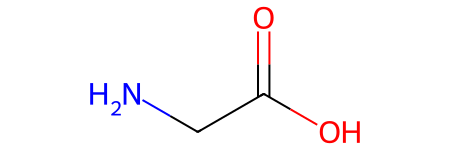

In [25]:
glycine = mol_list[0]
glycine

In [26]:
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(glycine, 2, nBits=1024, bitInfo=bi)
fp_arr = numpy.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, fp_arr)
print(fp_arr)
print(np.nonzero(fp_arr))

NameError: name 'numpy' is not defined

In [ ]:
prints = [(glycine, x, bi) for x in fp.GetOnBits()]
prints

[(<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  27,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  80,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  147,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  389,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdk

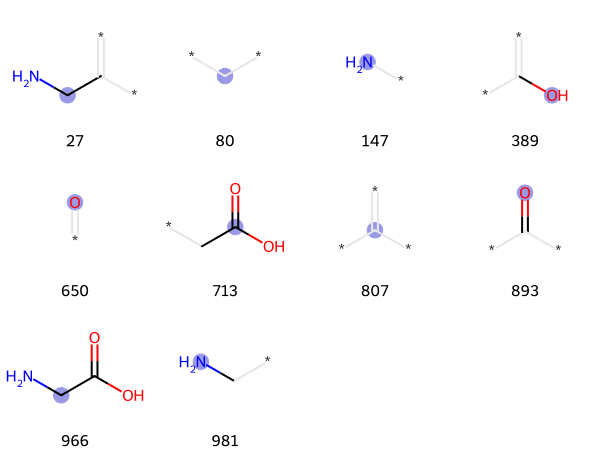

In [ ]:
# Below are 10 substructure patterns that are present in glycine
Draw.DrawMorganBits(prints, molsPerRow=4, legends=[str(x) for x in fp.GetOnBits()])

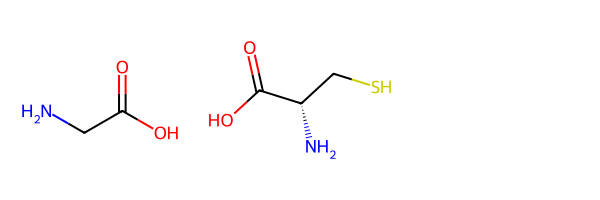

In [ ]:
cysteine = mol_list[3]
img = Draw.MolsToGridImage([glycine, cysteine])
img

In [ ]:
fp2 = AllChem.GetMorganFingerprintAsBitVect(cysteine, 2, nBits=1024, bitInfo=bi)
print('gly', list(fp.GetOnBits()))
print('cys', list(fp2.GetOnBits()))

common = set(fp.GetOnBits()) & set(fp2.GetOnBits())
combined = set(fp.GetOnBits()) | set(fp2.GetOnBits())
print('common', len(common))
print('combined', len(combined))
print('Tanimoto similarity', len(common) / len(combined))
print(DataStructs.TanimotoSimilarity(fp, fp2))

gly [27, 80, 147, 389, 650, 713, 807, 893, 966, 981]
cys [1, 48, 80, 147, 229, 321, 389, 403, 435, 650, 786, 807, 820, 825, 893, 902]
common 6
combined 20
Tanimoto similarity 0.3
0.3
